In [1]:
library(ggplot2)
library(dplyr)
library(plyr)
library(reshape2)
library(tidyr) 
library(patchwork)
library(viridis)
library(ggthemes)
library(showtext)
library(scales)
theme_set(theme_minimal())
Sys.setlocale("LC_TIME", "C") # żeby daty były po angielsku

options(repr.plot.width = 12, repr.plot.height = 7)
font_add_google("Roboto", "mont")
showtext_auto()

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: viridisLite

Warning

[1] "C"

In [2]:
df <- read.csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")
df1 <- read.csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
countries <- c("Poland", "Sweden", "Czech Republic")

rest <- df %>%
  filter(CountryName %in% countries) %>%
  mutate(Date = as.Date(as.character(Date), "%Y%m%d"))


df1$location <- revalue(df1$location, c("Czechia" = "Czech Republic"))

general <- df1 %>% 
  filter(location %in% countries) %>%
  mutate(date = as.Date(date))


In [3]:
colormap <- c("#C28600", "#DC267F", "#648FFF")#DC267F

Warning message:
“Column `location`/`CountryName` joining factors with different levels, coercing to character vector”
Warning message:
“Removed 14 rows containing missing values (geom_path).”
Warning message:
“Removed 75 rows containing missing values (geom_path).”


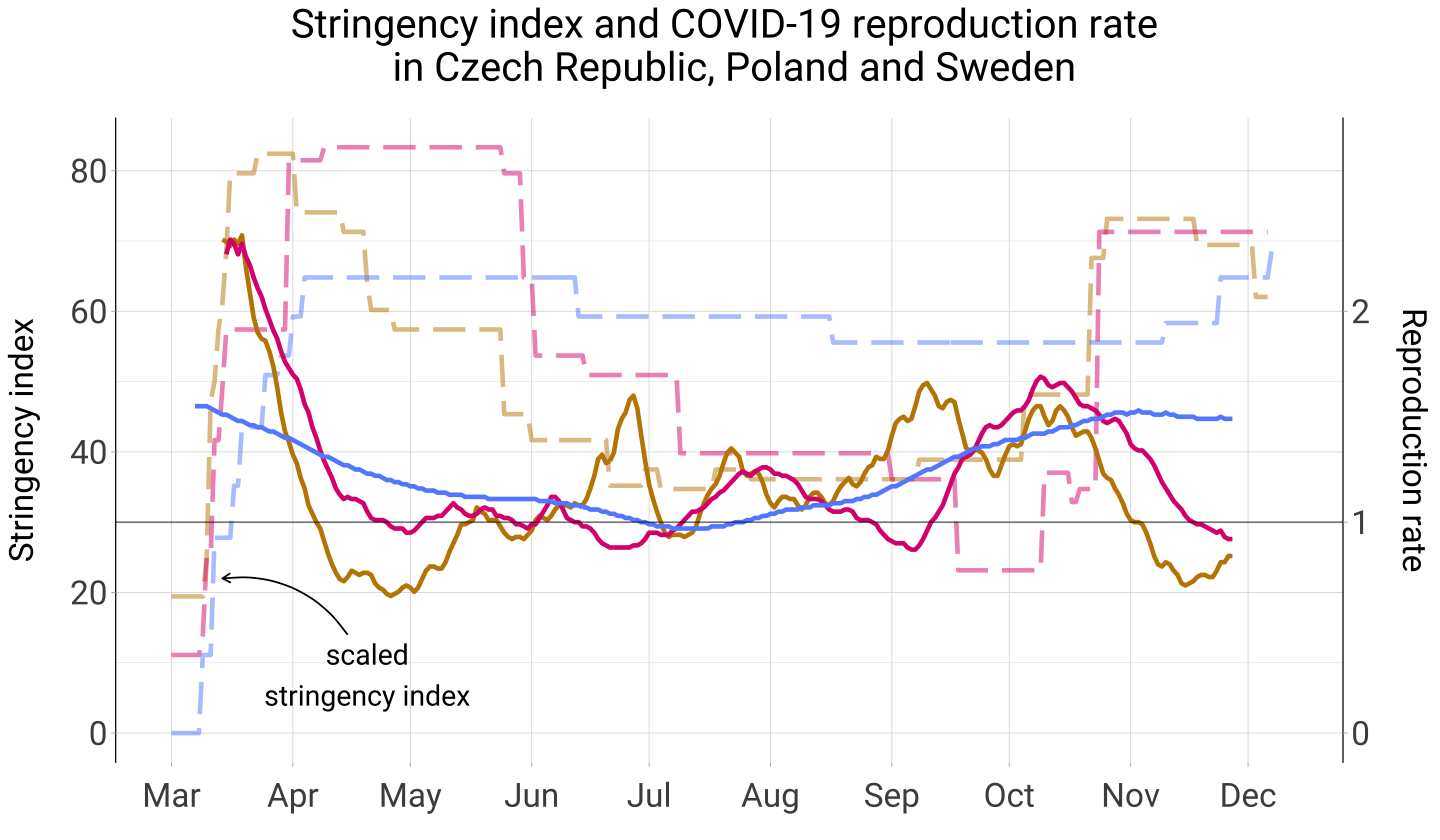

In [4]:
connected <- inner_join(general %>% select(location, date, new_cases_smoothed_per_million, reproduction_rate), 
                        rest %>% select(CountryName, Date, StringencyIndex), 
                        by = c("location" = "CountryName", "date" = "Date"))

coeff <- 30

ggplot(connected[connected$date >= "2020-03-01", ], aes(x = date)) +
  geom_line(aes(y = StringencyIndex, color = location), linetype = "longdash", size = 1.3, alpha = 0.5)  +
  annotate(geom = "curve", x = as.Date("2020-04-15"), y = 14, 
           xend = as.Date("2020-03-14"), yend = 22, 
           curvature =0.3, arrow = arrow(length = unit(2, "mm"))) +
  annotate(geom = "text", x = as.Date("2020-04-20"), y = 10,
           label = format("scaled\nstringency index"), hjust = "center", vjust = 0.7, size=6,
            family = "mont") +
  geom_line(aes(y = reproduction_rate*coeff, color = location), size = 1.3) +
  scale_y_continuous(name = "Stringency index",
                     sec.axis = sec_axis(~./coeff, name = "Reproduction rate")) +
  scale_x_date(date_breaks = "1 month", date_labels = "%b") +
# scale_x_date(breaks = date_breaks("1 month"), limits = c(min = "2020-03-01", max = "2020-11-02"),
#             expand = c(0, 0), labels = date_format("%b")) +
  scale_color_manual(values = colormap) +
  xlab("") +
  theme_light()+
  ggtitle("Stringency index and COVID-19 reproduction rate \n in Czech Republic, Poland and Sweden") + 
  theme(axis.line.y.left = element_line(),
        axis.line.y.right = element_line(),
        axis.title.y = element_text(margin = unit(c(0, 7, 0, 0), "mm")), 
        axis.title.y.right = element_text(margin = unit(c(0, 0, 0, 7), "mm")), 
        panel.grid.minor.x = element_blank(),
        panel.border = element_blank(),
        legend.position = "none",
        text = element_text(size = 20, family = "mont"),
        axis.text.x = element_text(size = 20, vjust = -2),
        axis.text.y = element_text(size = 20),
        plot.title = element_text(hjust = 0.5, margin = unit(c(0, 0, 7, 0), "mm"))) +
  geom_hline(yintercept = 1*coeff, alpha=.5)

Warning message:
“Removed 81 rows containing missing values (geom_path).”


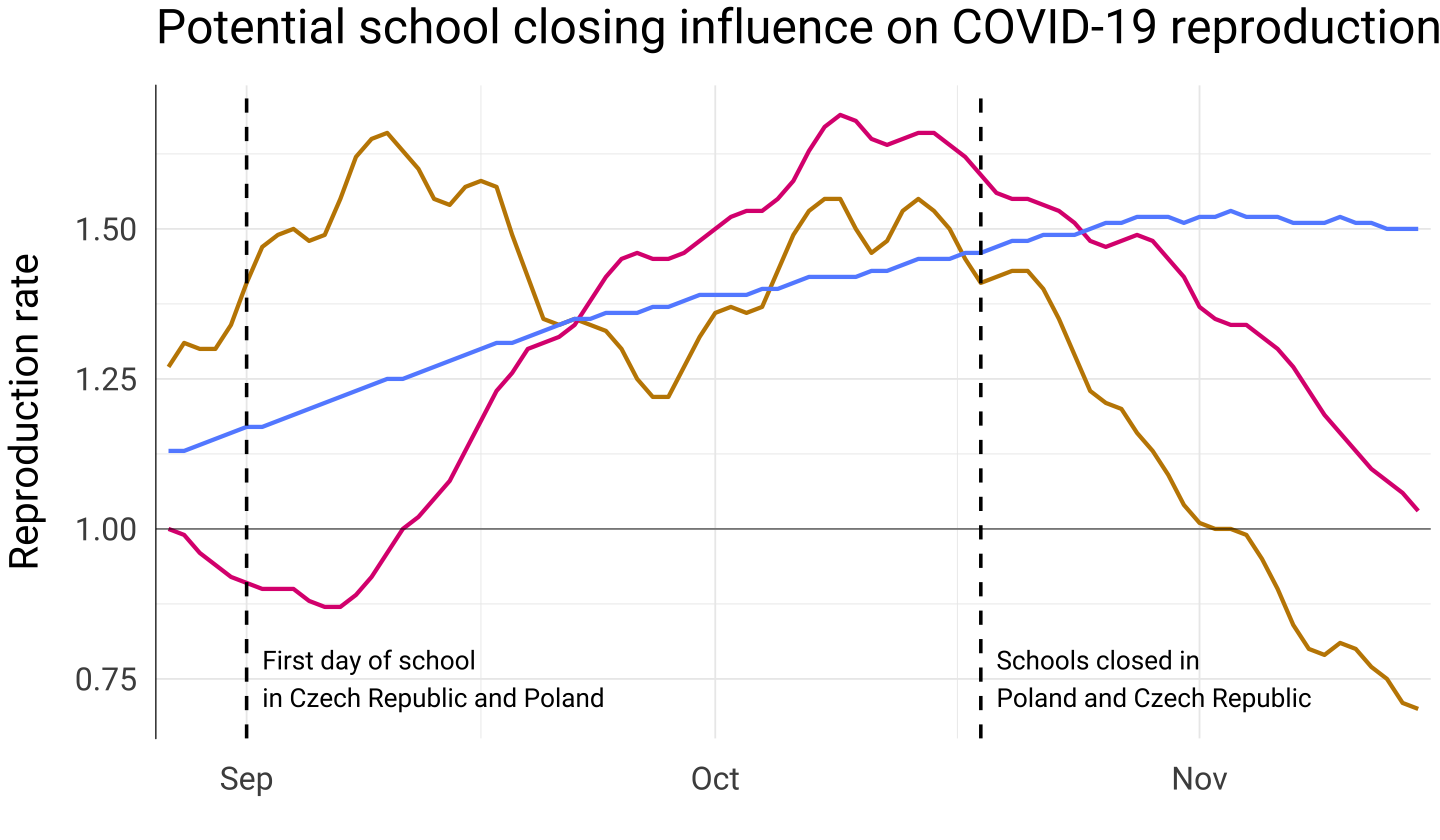

In [5]:
p2 <- ggplot(general[general$date > "2020-08-25", ], aes(x = date, y = reproduction_rate, color = location)) +
  geom_line(size = 1.2) +
  geom_hline(yintercept = 1, alpha = .5) + 
  scale_color_manual(values = colormap) +
  geom_vline(xintercept = as.numeric(as.Date("2020-09-01")), linetype = "dashed", size = 1) + 
  geom_vline(xintercept = as.numeric(as.Date("2020-10-18")), linetype = "dashed", size = 1) +
  # geom_text(aes(x = as.Date("2020-09-07", "%Y-%m-%d"), label="School starts", y=0.75), colour="black") + 
  # geom_text(aes(x = as.Date("2020-10-25", "%Y-%m-%d"),
  #               label="School closed in\nPoland and Czech Reoublic", y=0.75), colour="black") +
  scale_x_date(date_breaks = "1 month", date_labels = "%b", limits = c(as.Date("2020-08-27"), as.Date("2020-11-15")), expand=c(0.01, 0.01)) +
  annotate(geom = "text", x = as.Date("2020-09-02", "%Y-%m-%d"), y=0.75,
           label = "First day of school\nin Czech Republic and Poland",
           hjust = 0, size = 5.5, family = "mont") +
  ggtitle("Potential school closing influence on COVID-19 reproduction rate") +
  annotate(geom = "text", x = as.Date("2020-10-19", "%Y-%m-%d"),
           label="Schools closed in\nPoland and Czech Republic",
           y=0.75, colour="black", hjust=0, family = "mont", size = 5.5) +
  theme(legend.position = "none",
       text = element_text(size = 24, family = "mont"),
       axis.title.y = element_text(margin = unit(c(0, 7, 0, 0), "mm")),
       axis.text.y = element_text(margin = unit(c(0, 3, 0, 0), "mm")),
       plot.title = element_text(margin = unit(c(0, 0, 8, 0), "mm")),
       axis.text.x = element_text(margin = unit(c(5, 0, 0, 0), "mm")),
       axis.line.y = element_line())+
  labs(x="", y="Reproduction rate")


p2

Warning message:
“Column `location`/`CountryName` joining factors with different levels, coercing to character vector”


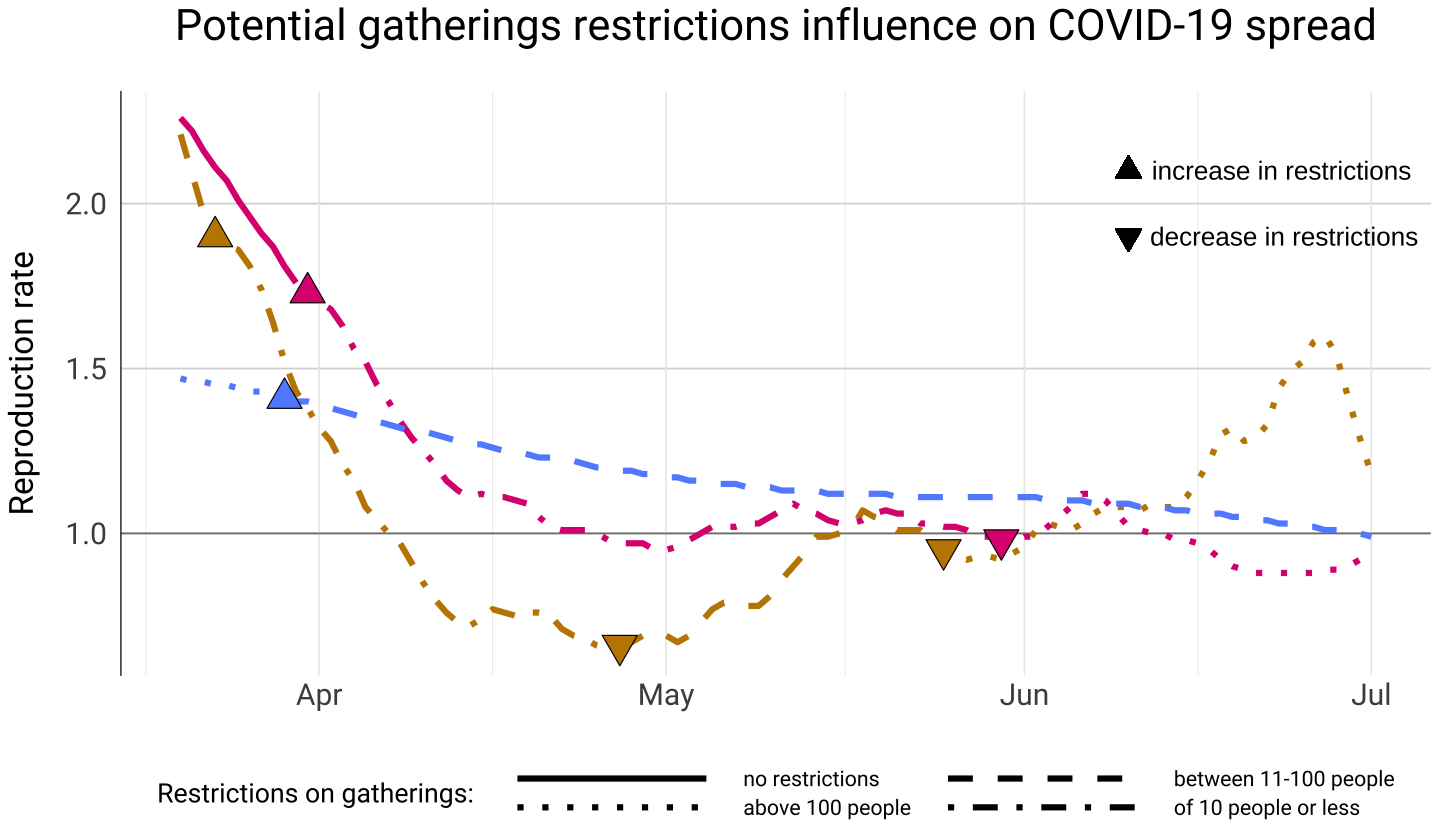

In [6]:
ourdata <- inner_join(general %>% select(location, date, new_cases_per_million, 
                                         reproduction_rate, positive_rate), 
                      rest %>% select(CountryName, Date, StringencyIndex, H6_Facial.Coverings, 
                                      C1_School.closing, C4_Restrictions.on.gatherings, H2_Testing.policy), 
                      by = c("location" = "CountryName", "date" = "Date"))


ourdata$location <- factor(ourdata$location,
                           levels = c('Czech Republic', 'Poland', 'Sweden'),
                           labels = c('Czech Republic', 'Poland', 'Sweden'))


ourdata$C4_Restrictions.on.gatherings = factor(ourdata$C4_Restrictions.on.gatherings,
                                               exclude = NULL,
                                               levels = c(0:4, NA),
                                               labels = c(
                                                 'no restrictions',
                                                 'above 100 people',
                                                 'above 100 people',
                                                 'between 11-100 people',
                                                 'of 10 people or less',
                                                 'no data'
                                               ))



segment <- 1
change <- 0

for (i in 2:nrow(ourdata)) {
  if (ourdata$location[i]==ourdata$location[i-1] 
      && ourdata$C4_Restrictions.on.gatherings[i]==ourdata$C4_Restrictions.on.gatherings[i-1]) {
    segment[i] <- segment[i-1]
  } else {
    segment[i] <- segment[i-1] + 1
  }
  if (ourdata$location[i]==ourdata$location[i-1]) {
    if (as.integer(
      ourdata$C4_Restrictions.on.gatherings[i])>as.integer(
      ourdata$C4_Restrictions.on.gatherings[i-1])) {
      change[i] <- 1
    }
    else if (as.integer(
      ourdata$C4_Restrictions.on.gatherings[i])<as.integer(
        ourdata$C4_Restrictions.on.gatherings[i-1])) {
      change[i] <- -1
    }
    else {
      change[i] <- 0
    }
    
  } else {
    change[i] <- 0
  }
}
ourdata$segment <- segment
ourdata$change <- change

colormap <- c("#C28600", "#DC267F", "#648FFF")#DC267F

ggplot(ourdata %>% filter(date >= "2020-03-20" , date <= "2020-07-01" ),aes(x = date, color = location)) + 
  geom_hline(yintercept = 1, alpha = 0.5) +
  geom_line(aes(y=reproduction_rate,
                linetype = C4_Restrictions.on.gatherings,
                group=segment), size = 1.75) +# mozna pomyslec czy to dodac
  geom_point(data = ourdata %>% filter(change == 1, date >= "2020-03-20" , date <= "2020-07-01"),
             aes(x=date, y=reproduction_rate),
             fill = colormap,
             color = "black",
             size = 7, shape = 24) + # 2 24
  geom_point(data = ourdata %>% filter(change == -1, date >= "2020-03-20" , date <= "2020-07-01"),
             aes(x=date, y=reproduction_rate),
             fill = c("#C28600", "#C28600", "#DC267F"),
             color = "black",
             size = 7, shape = 25) + # 6 25
  geom_point(aes(x=as.Date("2020-06-10"), y= c(2.1)), shape=24, size = 5,
             fill ="black", color ="black")+
  geom_point(aes(x=as.Date("2020-06-10"), y= c(1.9)), shape=25, size = 5,
             fill = "black", color ="black")+
  annotate(geom = "text", x = as.Date("2020-06-16"), y=2.1,
           label = " increase in restrictions", hjust = 0.2, size = 5.5) +
  annotate(geom = "text", x = as.Date("2020-06-16"), y=1.9,
           label = " decrease in restrictions", hjust= 0.2, size = 5.5) +
  # annotate(geom = "text", x = as.Date("2020-10-19", "%Y-%m-%d"),
  #          label="School closed in\nPoland and Czech Reoublic",
  #          y=0.75, colour="black", hjust=0, fontface =2) +
  scale_x_date() +
  labs(linetype = "Restrictions on gatherings: ",
       color = "Country: ",
       y=format("Reproduction rate"),
       x = "",
       title = "Potential gatherings restrictions influence on COVID-19 spread") +
  scale_linetype_manual(values = c('no restrictions'='solid', 
               'above 100 people'='dotted', 
               'between 11-100 people'='dashed',
               'of 10 people or less'='dotdash',
               'no data'='blank'
    ),
    limits = c('no restrictions', 'above 100 people',
               'between 11-100 people', 'of 10 people or less')) +
  scale_color_manual(values = colormap) +
  guides(linetype = guide_legend(keywidth = unit(5, 'cm'), nrow=2), color = "none", fill="none") +
  theme_hc() + 
  theme(legend.position="bottom", legend.box = "vertical",
        axis.title.y = element_text(angle = 90, size = 20, margin = unit(c(0, 6, 0, 0), "mm")),
        text = element_text(size = 16, family = "mont"),
        plot.title = element_text(size = 26, hjust = 0.5, margin = unit(c(0, 0, 10, 0), "mm")),
        axis.text = element_text(size = 18),
        panel.grid.major.x = element_line(),
        panel.grid.minor.x = element_line(),
        axis.line.y = element_line(),
        axis.text.y = element_text(margin = unit(c(0, 2, 0, 0), "mm"))
        ) -> plot
plot